# Blue Carbon Cost Tool Prototype

This notebooks prototypes the workflow for the Blue Carbon Cost tool. The tool is a excel base tool "[Blue Carbon Cost Tool - Excel full functionality (only if needed).xlsm](https://docs.google.com/spreadsheets/d/1lcmLolkwedgDrJJ54VvlMy3dn40rKjFi/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true)" that allows the user to estimate the cost of a blue carbon project. The tool has been documented in the [2305 - Blue Carbon Tool - Guidance Document_vBetaTest (1)](https://docs.google.com/document/d/1lvktavnyMVnzBpULrCF3sg5eah6xA-PS/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true).

For the current prototype we will use the "[Carbon-Cost Data Upload.xlsm](https://docs.google.com/spreadsheets/d/170jYrXpTSUlQfsMXXjN5v6L2PIlMYUXu/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true)" file that has been manually simplified to only contain the data upload and the cost estimation. To reproduce this notebook you need to add the "master table" to this excel file in your local. You can copy the "master table" from these other excel file "[data_ingestion.xlsm](https://docs.google.com/spreadsheets/d/1BOadf1aM7SAjZcVYcvpljsPoNq0NOTHb/edit?usp=drive_link&ouid=102705365484464103073&rtpof=true&sd=true)".

## Setup

### Library import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import sys

import pandas as pd  # noqa: I001

sys.path.append("../src/bcc_model")

from v1.blue_carbon_project import BlueCarbonProject
from v1.breakeven_cost_calculator import BreakevenCostCalculator
from v1.cost_calculator import CostCalculator
from v1.sensitivity_analysis import plot_sensitivity_analysis
from v1.utils import generate_master_table

## Blue Carbon Cost Tool 

### Read data

In [3]:
# Import excel with the import datai
data_path = "../excel/Carbon-Cost Data Upload.xlsm"

**Create the master table**

To replicate the prototype we need to crete the `master_table` that the back-end team creates when the Excel is ingested. This table contains all the data contained in the `Cost` and `Carbon` tables of the Excel file.

In [4]:
master_table = generate_master_table(data_path)
master_table.head()

,country,country_code,activity,ecosystem,size_ha,feasibility_analysis_cost,planning_and_admin_cost,data_collection_and_field_cost,community_representation_liaison_cost,blue_carbon_project_planning_cost,...,extent,extent_historic,unprotected_extent,loss_rate,restorable_land,tier_1_ipcc_default_value,tier_2_country_specific_rate,tier_1_global_emission_factor,tier_2_country_specific_emission_factor_agb,tier_2_country_specific_emission_factor_soc
0,United States,USA,Restoration,Mangrove,500,100000,166766.666667,26666.666667,126500.000000,100000,...,42057.40171,231272.5243,20077.3163,-0.008868,9665.780512,5.94,17.2349,27.2,55.227609,58.002081
1,Indonesia,IDN,Restoration,Mangrove,500,50000,166766.666667,26666.666667,71183.333333,100000,...,2901690.307,2930508.086,2028220.962,-0.003716,204536.1679,5.94,29.5,27.2,355.398394,71.876642
2,Australia,AUS,Restoration,Mangrove,500,70000,166766.666667,26666.666667,113016.666667,115000,...,1004148.846,1013552.136,482831.9666,-0.001498,69160.39725,5.94,7.285,27.2,197.881108,59.762089
3,The Bahamas,BHS,Restoration,Mangrove,500,70000,166766.666667,26666.666667,103100.000000,125000,...,150839.0825,144788.5852,34035.8866,-0.007321,9842.169833,5.94,7.5,27.2,21.830982,107.946528
4,Kenya,KEN,Restoration,Mangrove,500,50000,166766.666667,26666.666667,66050.000000,100000,...,54121.50058,54080.01031,44742.4502,-0.002781,1609.6981,5.94,19,27.2,91.779817,79.040056


**Read other tables**

In [5]:
# Open the excel file - tab 'Base_size_table'
base_size = pd.read_excel(data_path, sheet_name="Base_size_table")

# Open the excel file - tab 'Base_increase'
base_increase = pd.read_excel(data_path, sheet_name="Base_increase")

base_size.head()

,id,activity,ecosystem,feasibility_analysis,conservation_planning_and_admin,data_collection_and_field_cost,community_representation,blue_carbon_project_planning,establishing_carbon_rights,financing_cost,validation,implementation_labor_planting,implementation_labor_hybrid,implementation_labor_hydrology,monitoring,baseline_reassessment,MRV,long_term_project_operating_cost
0,1,Restoration,Mangrove,500,2500,500,2500,500,500,500,500,0,0,0,2500,500,500,2500
1,2,Conservation,Mangrove,20000,20000,20000,20000,20000,20000,20000,20000,0,0,0,20000,20000,20000,20000
2,3,Restoration,Seagrass,500,2500,500,2500,500,500,500,500,0,0,0,2500,500,500,2500
3,4,Conservation,Seagrass,20000,20000,20000,20000,20000,20000,20000,20000,0,0,0,20000,20000,20000,20000
4,5,Restoration,Salt marsh,500,2500,500,2500,500,500,500,500,0,0,0,2500,500,500,2500


### Create example projects

In this section we will replicate the steps followed in the `Dashboard` sheet of the [`Blue Carbon Cost Tool - Excel full functionality (only if needed)`](https://docs.google.com/spreadsheets/d/1lcmLolkwedgDrJJ54VvlMy3dn40rKjFi/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true) Excel file following the `Deep dive: Excel dashboard` section in the [`Blue Carbon Tool - Guidance Document`](https://docs.google.com/document/d/1lvktavnyMVnzBpULrCF3sg5eah6xA-PS/edit?usp=sharing&ouid=102705365484464103073&rtpof=true&sd=true).

**(1) Input - Project parameters**

This section outlines the standard project parameters for a hypothetical blue carbon project. Users have the flexibility to adjust these parameters according to their preferences or specific requirements.

In [6]:
## EXAMPLE 1
# project_name = "Conservation_Mangrove_Indonesia"
# loss_rate_used = "project-specific"
## Example usage for a restoration project
# project = BlueCarbonProject(
#    activity="Conservation",  # ['Restoration', 'Conservation']
#    ecosystem="Mangrove",  #  ['Mangrove', 'Seagrass', 'Salt marsh']
#    country="Indonesia",  # [
#    #'United States', 'Indonesia', 'Australia', 'The Bahamas', 'Kenya', 'Mexico',
#    # 'Colombia', 'India', 'China']
#    master_table=master_table,
#    base_size=base_size,
#    base_increase=base_increase,
#    carbon_price=20,  # Default value 30
#    carbon_revenues_to_cover="Opex",  # ['Opex', 'capex+Opex']
#    project_size_ha=10000,
#    # restoration_activity='Planting', # ['Planting', 'Hybrid', 'Hydrology']
#    # sequestration_rate_used='Tier 1 - IPCC default value', # ['Tier 1 - IPCC default value',
#    #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
#    # project_specific_sequestration_rate=None,
#    # planting_success_rate=0.8, # Default value 0.8
#    loss_rate_used="project-specific",  # ['National average', 'project-specific']
#    project_specific_loss_rate=-0.001, # -0.10% loss rate
#    emission_factor_used="Tier 2 - Country-specific emission factor",
#    # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
#    #  'Tier 3 - Project specific emission factor']
#    # tier_3_project_specific_emission="AGB and SOC separately",
#    # ['One emission factor', 'AGB and SOC separately']
#    # tier_3_project_specific_emission_one_factor=0.5,
#    # tier_3_emission_factor_AGB=0.5,
#    # tier_3_emission_factor_SOC=0.5
# )

In [7]:
#### EXAMPLE
# project_name = "Restoration_China_Salt_marsh"
# loss_rate_used = "project-specific"
## Example usage for a restoration project
# project = BlueCarbonProject(
#    activity="Restoration",  # ['Restoration', 'Conservation']
#    ecosystem="Salt marsh",  #  ['Mangrove', 'Seagrass', 'Salt marsh']
#    country="China",  # [
#    #'United States', 'Indonesia', 'Australia', 'The Bahamas', 'Kenya', 'Mexico',
#    # 'Colombia', 'India', 'China']
#    master_table=master_table,
#    base_size=base_size,
#    base_increase=base_increase,
#    carbon_price=30,  # Default value 30
#    carbon_revenues_to_cover="Opex",  # ['Opex', 'capex+Opex']
#    project_size_ha=500,
#    restoration_activity='Hydrology', # ['Planting', 'Hybrid', 'Hydrology']
#    sequestration_rate_used='Tier 1 - IPCC default value', # ['Tier 1 - IPCC default value',
#    #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
#    # project_specific_sequestration_rate=None,
#    planting_success_rate=0.8, # Default value 0.8
#    # loss_rate_used="project-specific",  # ['National average', 'project-specific']
#    # project_specific_loss_rate=-0.001, # -0.10% loss rate
#    # emission_factor_used="Tier 2 - Country-specific emission factor",
#    # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
#    #  'Tier 3 - Project specific emission factor']
#    # tier_3_project_specific_emission="AGB and SOC separately",
#    # ['One emission factor', 'AGB and SOC separately']
#    # tier_3_project_specific_emission_one_factor=0.5,
#    # tier_3_emission_factor_AGB=0.5,
#    # tier_3_emission_factor_SOC=0.5
# )

In [8]:
#### EXAMPLE 3
#
# project_name = "Restoration_Mexico_Mangrove"
## loss_rate_used = "project-specific"
## Example usage for a restoration project
# project = BlueCarbonProject(
#    activity="Restoration",  # ['Restoration', 'Conservation']
#    ecosystem="Mangrove",  #  ['Mangrove', 'Seagrass', 'Salt marsh']
#    country="Mexico",  # [
#    #'United States', 'Indonesia', 'Australia', 'The Bahamas', 'Kenya', 'Mexico',
#    # 'Colombia', 'India', 'China']
#    master_table=master_table,
#    base_size=base_size,
#    base_increase=base_increase,
#    carbon_price=30,  # Default value 30
#    carbon_revenues_to_cover="capex+Opex",  # ['Opex', 'capex+Opex']
#    project_size_ha=500,
#    restoration_activity="Planting",  # ['Planting', 'Hybrid', 'Hydrology']
#    sequestration_rate_used="Tier 2 - Country-specific rate",  # ['Tier 1 - IPCC default value',
#    #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
#    # project_specific_sequestration_rate=None,
#    planting_success_rate=0.8,  # Default value 0.8
#    # loss_rate_used="project-specific",  # ['National average', 'project-specific']
#    # project_specific_loss_rate=-0.001, # -0.10% loss rate
#    # emission_factor_used="Tier 2 - Country-specific emission factor",
#    # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
#    #  'Tier 3 - Project specific emission factor']
#    # tier_3_project_specific_emission="AGB and SOC separately",
#    # ['One emission factor', 'AGB and SOC separately']
#    # tier_3_project_specific_emission_one_factor=0.5,
#    # tier_3_emission_factor_AGB=0.5,
#    # tier_3_emission_factor_SOC=0.5
# )

In [9]:
# EXAMPLE 1
project_name = "Restoration_Mangrove_Colombia"
# Example usage for a restoration project
project = BlueCarbonProject(
    project_size_ha=250,
    activity="Restoration",
    ecosystem="Mangrove",
    country="Colombia",
    master_table=master_table,
    base_size=base_size,
    base_increase=base_increase,
    carbon_price=30,  # Default value 30
    carbon_revenues_to_cover="Opex",  # ['Opex', 'capex+Opex']
    restoration_activity="Planting",  # ['Planting', 'Hybrid', 'Hydrology']
    sequestration_rate_used="Tier 2 - Country-specific rate",  # ['Tier 1 - IPCC default value',
    #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
    project_specific_sequestration_rate=None,
    planting_success_rate=0.8,  # Default value 0.8
    # loss_rate_used="National average",  # ['National average', 'project-specific']
    # project_specific_loss_rate=-0.1, # -0.10% loss rate
    # emission_factor_used="Tier 2 - Country-specific emission factor",
    # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
    #  'Tier 3 - Project specific emission factor']
    # tier_3_project_specific_emission="AGB and SOC separately",
    # ['One emission factor', 'AGB and SOC separately']
    # tier_3_project_specific_emission_one_factor=0.5,
    # tier_3_emission_factor_AGB=0.5,
    # tier_3_emission_factor_SOC=0.5
)

In [10]:
# EXAMPLE 2
project_name = "Restoration_Mangrove_Indonesia"
# Example usage for a restoration project
project = BlueCarbonProject(
    project_size_ha=230,
    activity="Restoration",
    ecosystem="Mangrove",
    country="Indonesia",
    master_table=master_table,
    base_size=base_size,
    base_increase=base_increase,
    carbon_price=30,  # Default value 30
    carbon_revenues_to_cover="capex+Opex",  # ['Opex', 'capex+Opex']
    restoration_activity="Planting",  # ['Planting', 'Hybrid', 'Hydrology']
    sequestration_rate_used="Tier 2 - Country-specific rate",  # ['Tier 1 - IPCC default value',
    #  'Tier 2 - Country-specific rate', 'Tier 3 - Project-specific rate']
    project_specific_sequestration_rate=None,
    planting_success_rate=0.6,  # Default value 0.8
    # loss_rate_used="National average",  # ['National average', 'project-specific']
    # project_specific_loss_rate=-0.1, # -0.10% loss rate
    # emission_factor_used="Tier 2 - Country-specific emission factor",
    # ['Tier 1 - Global emission factor', 'Tier 2 - Country-specific emission factor',
    #  'Tier 3 - Project specific emission factor']
    # tier_3_project_specific_emission="AGB and SOC separately",
    # ['One emission factor', 'AGB and SOC separately']
    # tier_3_project_specific_emission_one_factor=0.5,
    # tier_3_emission_factor_AGB=0.5,
    # tier_3_emission_factor_SOC=0.5
)

**(2) Input - Model assumptions** 

Users can modify model assumptions by overriding the standard base values for conducting bespoke project analysis.

In [11]:
# project.set_additional_assumptions(
#    # verification_frequency,
#    discount_rate=1.3,
#    # carbon_price_increase,
#    buffer=0.28,
#    # baseline_reassessment_frequency,
#    conservation_project_length=30,
#    # restoration_project_length,
#    # restoration_rate
# )

**(3) Input - Cost components**

The model always displays these standard costs, but users have the option to override them for customized project analysis.


In [13]:
# project.override_cost_input(
#    feasibility_analysis=30000
#    # conservation_planning_and_admin,
#    # data_collection_and_field_cost,
#    # community_representation,
#    # blue_carbon_project_planning,
#    # establishing_carbon_rights,
#    # validation,
#    # implementation_labor,
#    # monitoring,
#    # maintenance,
#    # community_benefit_sharing_fund,
#    # carbon_standard_fees,
#    # baseline_reassessment,
#    # MRV,
#    # long_term_project_operating,
#    # financing_cost
# )

**(4) Input – Restoration plan** 

Used for restoration projects only. Users can use this section to have more control over the restoration plan input.
To have greater control over the timeline of the restoration plan, kindly provide the annual hectares restored in the blue space provided. Ensure that the cumulative sum does not exceed your original project size and remains within your designated project timeline. 

In [14]:
restoration_plan = {}
restoration_plan[-1] = 230
restoration_plan.update(dict.fromkeys(range(1, 31), 0))
cumulative_size = sum(restoration_plan.values())
if cumulative_size <= project.project_size_ha:
    project.update_restoration_plan(restoration_plan)

**Check all input parameters**

In [15]:
project_parameters = project.get_project_parameters()

### Project Parameters
| Parameter                                      | Value                                   |
| ---------------------------------------------- | --------------------------------------- |
| Project size (ha) | 230 |
| Initial carbon price assumption ($) | 30 |
| Country | Indonesia |
| Ecosystem | Mangrove |
| Activity | Restoration |
| Carbon revenues to cover | capex+Opex |
| Carbon revenues will not cover | None |
**Additional parameters for a Restoration project**
| Activity type - Restoration | Planting |
| Sequestration rate used | Tier 2 - Country-specific rate |
| Tier 2 - Country-specific rate | 29.5 |
| Project-specific sequestration rate (tCO2e/ha/yr) | None |
| Planting Success Rate (%) | 60.0 |
### Assumptions
| Parameter                                      | Value                                   |
| ---------------------------------------------- | --------------------------------------- |
| Verification frequency (yr) | 5 |
| Discount rate (%) | 4.0 |
| Carbon price increase (%) | 1.5 |
| Buffer (%) | 20 |
| Baseline reassessment frequency (yr) | 10 |
**Additional assumptions for a Restoration project**
| Restoration rate (ha/yr) | 250 |
| Restoration project length (yr) | 20 |
### Cost Inputs
| Parameter                                      | Value                                   |
| ---------------------------------------------- | --------------------------------------- |
| **CAPEX**                                      |                                         |
| Feasibility_analysis ($/project) | 50,000 |
| Conservation planning and admin ($/yr) | 166,767 |
| Data collection and field cost ($/yr) | 26,667 |
| Community representation ($/yr) | 71,183 |
| Blue carbon project planning ($/project) | 100,000 |
| Establishing carbon rights ($/yr) | 46,667 |
| Validation ($/project) | 50,000 |
| Implementation labor ($/ha) | 2,000 |
| **OPEX**                                       |                                         |
| Monitoring ($/yr) | 15,000 |
| Maintenance (% of implementation labor) | 8 |
| Community benefit sharing fund (% of revenue) | 50 |
| Carbon standard fees ($/credit) | 0.20 |
| Baseline reassessment ($/event) | 40,000 |
| MRV ($/event) | 75,000 |
| Long-term project operating ($/yr) | 26,400 |
| **Other**                                       |                                         |
| Financing cost (% of capex) | 5 |
### Restoration Plan
| Year                                           | Annual ha                               |
| ---------------------------------------------- | --------------------------------------- |
| -1 | 230 |
| 1 | 0 |
| 2 | 0 |
| 3 | 0 |
| 4 | 0 |
| 5 | 0 |
| 6 | 0 |
| 7 | 0 |
| 8 | 0 |
| 9 | 0 |
| 10 | 0 |
| 11 | 0 |
| 12 | 0 |
| 13 | 0 |
| 14 | 0 |
| 15 | 0 |
| 16 | 0 |
| 17 | 0 |
| 18 | 0 |
| 19 | 0 |
| 20 | 0 |
| 21 | 0 |
| 22 | 0 |
| 23 | 0 |
| 24 | 0 |
| 25 | 0 |
| 26 | 0 |
| 27 | 0 |
| 28 | 0 |
| 29 | 0 |
| 30 | 0 |

### Calculate costs

In [16]:
cost_calculator = CostCalculator(project)

**(5) Output - Project summary** 

This table provides a concise summary “snapshot” of the key economic outcomes for the hypothetical blue carbon project. 

In [17]:
cost_summary = cost_calculator.get_summary()

### Project Summary
| Parameter                            | Value                                             |
| ------------------------------------ | ------------------------------------------------- |
| Project | Indonesia Mangrove Restoration (230 ha) |
| $/tCO2e (total cost, NPV) | $49 |
| $/ha | $14,009 |
| NPV covering cost | $-1,863,338 |
| IRR when priced to cover opex | nan% |
| IRR when priced to cover total costs | nan% |
| Total cost (NPV) | $3,222,126 |
| Capital expenditure (NPV) | $1,697,037 |
| Operating expenditure (NPV) | $1,525,089 |
| Credits issued | 65,136 |
| Total revenue (NPV) | $1,358,789 |
| Total revenue (non-discounted) | $2,293,164 |
| Financing cost | $91,590 |
| Funding gap (NPV) | $1,863,338 |
| Funding gap per tCO2e (NPV) | $28.6 |
| Community benefit sharing fund % of revenue | 50% |

**(6) Output - Detailed cost summary**

This table shows a comprehensive breakdown of each cost component for the hypothetical blue carbon project. 

In [18]:
cost_estimates = cost_calculator.get_cost_estimates()

### Cost Estimates
| Cost estimates (USD)   | Total cost      | NPV             |
| ---------------------- | --------------- | --------------- |
| **Capital expenditure** | **$1,831,800** | **$1,697,037** |
| Feasibility analysis | $50,000 | $50,000 |
| Conservation planning and admin | $667,067 | $629,559 |
| Data collection and field costs | $80,000 | $76,963 |
| Community representation / liaison | $284,733 | $268,724 |
| Blue carbon project planning | $100,000 | $88,900 |
| Establishing carbon rights | $140,000 | $129,504 |
| Validation | $50,000 | $44,450 |
| Implementation labor | $460,000 | $408,938 |
| **Operating expenditure** | **$2,522,563** | **$1,525,089** |
| Monitoring | $300,000 | $181,226 |
| Maintenance | $114,954 | $94,532 |
| Community benefit sharing fund | $1,146,582 | $679,394 |
| Carbon standard fees | $13,027 | $7,870 |
| Baseline reassessment | $120,000 | $75,812 |
| MRV | $300,000 | $167,296 |
| Long-term project operating | $528,000 | $318,958 |
| **Total cost** | **$4,354,363** | **$3,222,126** |

**(7) Output - Sensitivity analysis**

This section presents a sensitivity analysis, illustrating the relative impact of changes to cost components on the hypothetical blue carbon project. 

Sensitivity analysis results exported to sensitivity_analysis_results.csv


## Sensitivity Analysis (±25%)

,Cost Input,Min % Change,Max % Change,Base params,Base Cost per tCO2e,Min Cost per tCO2e,Max Cost per tCO2e
0,feasibility_analysis,-0.387943,0.386443,50000.000000,49.467675,49.275769,49.659581
1,conservation_planning_and_admin,-4.884657,4.657171,166766.666667,49.467675,47.051348,51.884001
2,data_collection_and_field_cost,-0.597141,0.593596,26666.666667,49.467675,49.172283,49.763067
3,community_representation,-2.084986,2.042402,71183.333333,49.467675,48.436281,50.499069
4,blue_carbon_project_planning,-0.689759,0.685034,100000.000000,49.467675,49.126467,49.808883
5,establishing_carbon_rights,-1.004804,0.994808,46666.666667,49.467675,48.970622,49.964728
6,financing_cost,-0.000000,0.000000,0.050000,49.467675,49.467675,49.467675
7,validation,-0.344880,0.343694,50000.000000,49.467675,49.297071,49.638279
8,implementation_labor,-3.906353,3.759494,2000.000000,49.467675,47.535293,51.400057
9,monitoring,-1.406108,1.386610,15000.000000,49.467675,48.772106,50.163244


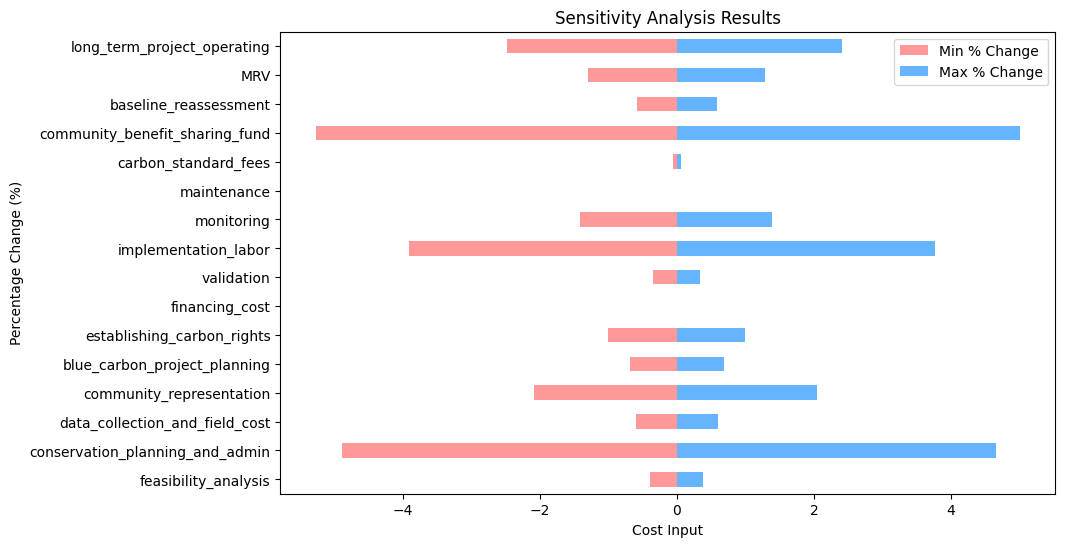

In [19]:
plot_sensitivity_analysis(project, CostCalculator, True)


**(8) Output - Projected cash flow** 

This section shows the projected cash flow timing for the hypothetical blue carbon project. 

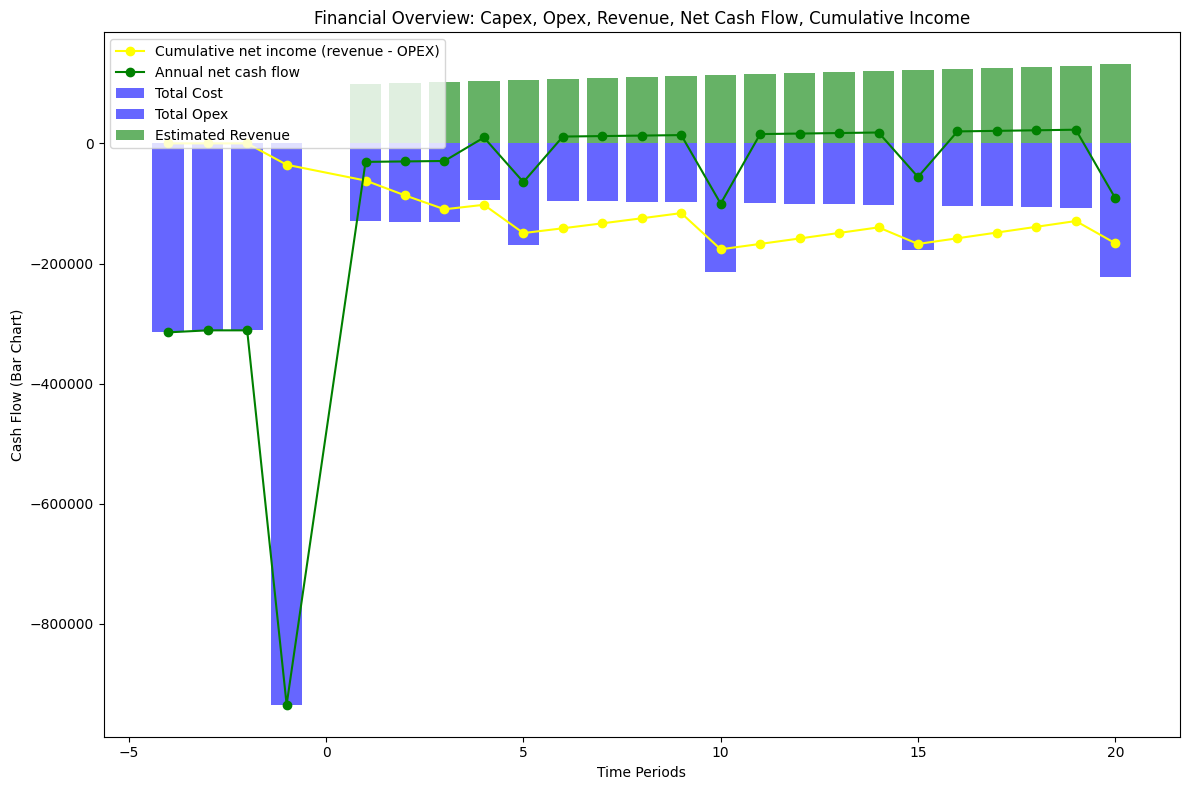

In [20]:
cost_graph = cost_calculator.plot_financial_data()
cost_graph

**“Pro Forma” sheet**

This section presents the yearly cash flows associated with the hypothetical blue carbon project.

In [21]:
yearly_cost_breakdown = cost_calculator.get_yearly_cost_breakdown()

### Pro Forma Financials
| Year | -4 | -3 | -2 | -1 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | Total | NPV |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| Feasibility analysis | -50000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -50000.0 | -50000.0 |
| Conservation planning and admin | -166767.0 | -166767.0 | -166767.0 | -166767.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -667067.0 | -629559.0 |
| Data collection and field costs | -26667.0 | -26667.0 | -26667.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -80000.0 | -76963.0 |
| Community representation / liaison | -71183.0 | -71183.0 | -71183.0 | -71183.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -284733.0 | -268724.0 |
| Blue carbon project planning | 0 | 0 | 0 | -100000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -100000.0 | -88900.0 |
| Establishing carbon rights | 0 | -46667.0 | -46667.0 | -46667.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -140000.0 | -129504.0 |
| Validation | 0 | 0 | 0 | -50000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -50000.0 | -44450.0 |
| Implementation labor | 0 | 0 | 0 | -460000.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -0.0 | -460000.0 | -408938.0 |
| **Total capex** | **-314617.0** | **-311283.0** | **-311283.0** | **-894617.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-0.0** | **-1831800.0** | **-1697037.0** |
| Monitoring | 0 | 0 | 0 | 0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -15000.0 | -300000.0 | -181226.0 |
| Maintenance | 0 | 0 | 0 | 0 | -38318.0 | -38318.0 | -38318.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -114954.0 | -94532.0 |
| Community benefit sharing fund | -0.0 | -0.0 | -0.0 | -0.0 | -49585.0 | -50329.0 | -51083.0 | -51850.0 | -52627.0 | -53417.0 | -54218.0 | -55031.0 | -55857.0 | -56695.0 | -57545.0 | -58408.0 | -59284.0 | -60174.0 | -61076.0 | -61992.0 | -62922.0 | -63866.0 | -64824.0 | -65797.0 | -1146582.0 | -679394.0 |
| Carbon standard fees | 0 | 0 | 0 | 0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -651.0 | -13027.0 | -7870.0 |
| Baseline reassessment | 0 | 0 | 0 | -40000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -40000.0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -40000.0 | -120000.0 | -75812.0 |
| MRV | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | -75000.0 | 0 | 0 | 0 | 0 | -75000.0 | 0 | 0 | 0 | 0 | -75000.0 | 0 | 0 | 0 | 0 | -75000.0 | -300000.0 | -167296.0 |
| Long-term project operating | 0 | 0 | 0 | 0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -33000.0 | -660000.0 | -398698.0 |
| **Total opex** | **-0.0** | **-0.0** | **-0.0** | **-40000.0** | **-129954.0** | **-130698.0** | **-131453.0** | **-93901.0** | **-169679.0** | **-95468.0** | **-96270.0** | **-97083.0** | **-97908.0** | **-213746.0** | **-99597.0** | **-100460.0** | **-101336.0** | **-102225.0** | **-178128.0** | **-104044.0** | **-104974.0** | **-105918.0** | **-106876.0** | **-222848.0** | **-2522563.0** | **-1525089.0** |
| **Total cost** | **-314617.0** | **-311283.0** | **-311283.0** | **-934617.0** | **-129954.0** | **-130698.0** | **-131453.0** | **-93901.0** | **-169679.0** | **-95468.0** | **-96270.0** | **-97083.0** | **-97908.0** | **-213746.0** | **-99597.0** | **-100460.0** | **-101336.0** | **-102225.0** | **-178128.0** | **-104044.0** | **-104974.0** | **-105918.0** | **-106876.0** | **-222848.0** | **-4354363.0** | **-3222126.0** |
| Est. credits issued | 0 | 0 | 0 | 0.0 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 3256.8 | 65136.0 | 0 |
| **Est. revenue** | **0** | **0** | **0** | **0.0** | **99170.0** | **100657.0** | **102167.0** | **103699.0** | **105255.0** | **106834.0** | **108436.0** | **110063.0** | **111714.0** | **113389.0** | **115090.0** | **116817.0** | **118569.0** | **120347.0** | **122153.0** | **123985.0** | **125845.0** | **127732.0** | **129648.0** | **131593.0** | **2293164.0** | **1358789.0** |
| Annual net cash flow | -314617.0 | -311283.0 | -311283.0 | -934617.0 | -30785.0 | -30041.0 | -29286.0 | 9798.0 | -64424.0 | 11366.0 | 12167.0 | 12980.0 | 13806.0 | -100357.0 | 15494.0 | 16357.0 | 17233.0 | 18122.0 | -55975.0 | 19941.0 | 20871.0 | 21815.0 | 22773.0 | -91255.0 | -2061199.0 | -1863338.0 |
| Annual net income (revenue – OPEX) | 0.0 | 0.0 | 0.0 | -40000.0 | -30785.0 | -30041.0 | -29286.0 | 9798.0 | -64424.0 | 11366.0 | 12167.0 | 12980.0 | 13806.0 | -100357.0 | 15494.0 | 16357.0 | 17233.0 | 18122.0 | -55975.0 | 19941.0 | 20871.0 | 21815.0 | 22773.0 | -91255.0 | -229399.0 | -166300.0 |
| Cumulative net income (revenue - OPEX) | 0.0 | 0.0 | 0.0 | -35560.0 | -61875.0 | -86566.0 | -109711.0 | -102265.0 | -149339.0 | -141354.0 | -133134.0 | -124703.0 | -116080.0 | -176351.0 | -167404.0 | -158322.0 | -149121.0 | -139817.0 | -167448.0 | -157983.0 | -148458.0 | -138885.0 | -129276.0 | -166300.0 | 0 | 0 |
| Cumulative net income (revenue - CAPEX - OPEX) | -314617.0 | -613928.0 | -901727.0 | -1732597.0 | -1758912.0 | -1783603.0 | -1806749.0 | -1799303.0 | -1846376.0 | -1838391.0 | -1830172.0 | -1821740.0 | -1813117.0 | -1873389.0 | -1864442.0 | -1855359.0 | -1846158.0 | -1836855.0 | -1864486.0 | -1855021.0 | -1845495.0 | -1835922.0 | -1826313.0 | -1863338.0 | 0 | 0 |

In [22]:
# Export to test_data to compare calculated results with expected ones
# yearly_cost_breakdown.to_csv("./test_data/Pro_forma_calculated_data.csv", index=False)

### Calculate breakeven price

Calculate carbon price to obtain NPV covering cost to zero.

In [23]:
# Calculate the breakeven cost
breakeven_cost_calculator = BreakevenCostCalculator(project)
breakeven_cost = breakeven_cost_calculator.calculate_breakeven_cost()
print(f"The breakeven cost is: {breakeven_cost['breakeven_carbon_price']}")

Iteration 0: NPV covering cost = -1943077.1792325089,
            Carbon price = 30
Iteration 1: NPV covering cost = -1267508.2171229832,
            Carbon price = 59.83107926849222
Iteration 2: NPV covering cost = -826821.0329704285,
            Carbon price = 79.29049060973182
Iteration 3: NPV covering cost = -539351.9437010116,
            Carbon price = 91.98425493315402
Iteration 4: NPV covering cost = -351830.09088311624,
            Carbon price = 100.2646520054491
Iteration 5: NPV covering cost = -229505.8250859715,
            Carbon price = 105.66612109908573
Iteration 6: NPV covering cost = -149711.25299765915,
            Carbon price = 109.18960772838399
Iteration 7: NPV covering cost = -97659.65315143391,
            Carbon price = 111.4880487287165
Iteration 8: NPV covering cost = -63705.35055108741,
            Carbon price = 112.98736789402346
Iteration 9: NPV covering cost = -41556.277929266915,
            Carbon price = 113.96540385802321
Iteration 10: NPV covering

### Export outputs as `JSON` file

In [24]:
if project.activity == "Restoration":
    output = {
        "initialCarbonPriceComputationOutput": {
            "sequestrationRate": project_parameters["Project parameters"][
                "For Restoration Projects Only"
            ][project.sequestration_rate_used],
            "plantingSuccessRate": 0.8,
            "carbonRevenuesToCover": project_parameters["Project parameters"][
                "Carbon revenues to cover"
            ],
            "initialCarbonPrice": project_parameters["Project parameters"][
                "Initial carbon price assumption ($)"
            ],
        },
        "breakevenPriceComputationOutput": {
            "carbonRevenuesToCover": breakeven_cost["project_params"]["Project parameters"][
                "Carbon revenues to cover"
            ],
            "sequestrationRate": project_parameters["Project parameters"][
                "For Restoration Projects Only"
            ][project.sequestration_rate_used],
            "plantingSuccessRate": 0.8,
            "initialCarbonPrice": float(
                breakeven_cost["project_params"]["Project parameters"][
                    "Initial carbon price assumption ($)"
                ]
            ),
        },
    }
else:
    output = {
        "initialCarbonPriceComputationOutput": {
            "lossRate": project_parameters["Project parameters"]["For Conservation Projects Only"][
                "project-specific"
            ],
            "carbonRevenuesToCover": project_parameters["Project parameters"][
                "Carbon revenues to cover"
            ],
            "initialCarbonPrice": project_parameters["Project parameters"][
                "Initial carbon price assumption ($)"
            ],
            "emissionFactors": {
                "emissionFactor": None,
                "emissionFactorAgb": project_parameters["Project parameters"][
                    "For Conservation Projects Only"
                ]["Country-specific emission factors"]["Emission factor AGB"],  # noqa: E501
                "emissionFactorSoc": project_parameters["Project parameters"][
                    "For Conservation Projects Only"
                ]["Country-specific emission factors"]["Emission factor SOC"],  # noqa: E501
            },
        },
        "breakevenPriceComputationOutput": {
            # Update values as first element of the list
            "lossRate": breakeven_cost["project_params"]["Project parameters"][
                "For Conservation Projects Only"
            ]["project-specific"],  # noqa: E501
            "carbonRevenuesToCover": breakeven_cost["project_params"]["Project parameters"][
                "Carbon revenues to cover"
            ],
            "initialCarbonPrice": float(
                breakeven_cost["project_params"]["Project parameters"][
                    "Initial carbon price assumption ($)"
                ]
            ),
            "emissionFactors": {
                "emissionFactor": None,
                "emissionFactorAgb": breakeven_cost["project_params"]["Project parameters"][
                    "For Conservation Projects Only"
                ]["Country-specific emission factors"]["Emission factor AGB"],  # noqa: E501
                "emissionFactorSoc": breakeven_cost["project_params"]["Project parameters"][
                    "For Conservation Projects Only"
                ]["Country-specific emission factors"]["Emission factor SOC"],  # noqa: E501
            },
        },
    }

initial_carbon_price_computation_output = {
    "totalProjectCost": {
        "total": {
            "total": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "capex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Capital expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "total": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "capex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Capital expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "leftover": {
        # review when is OPEX + CAPEX
        "total": {
            "total": int(
                cost_summary["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "leftover": int(
                cost_summary["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if project_parameters["Project parameters"]["Carbon revenues to cover"] == "Opex"
            else int(
                cost_summary["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if project_parameters["Project parameters"]["Carbon revenues to cover"] == "Opex"
            else int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "total": int(
                cost_summary["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "leftover": int(
                cost_summary["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if project_parameters["Project parameters"]["Carbon revenues to cover"] == "Opex"
            else int(
                cost_summary["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if project_parameters["Project parameters"]["Carbon revenues to cover"] == "Opex"
            else int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "summary": {
        "$/tCO2e (total cost, NPV)": int(
            cost_summary["Project summary"]["$/tCO2e (total cost, NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "$/ha": int(cost_summary["Project summary"]["$/ha"].replace("$", "").replace(",", "")),
        "NPV covering cost": int(
            cost_summary["Project summary"]["NPV covering cost"].replace("$", "").replace(",", "")
        ),
        # double check this attribute - this value should be the same as the NPV covering cost so how is it used?  # noqa: E501
        "Leftover after OpEx / total cost": int(
            cost_summary["Project summary"]["NPV covering cost"].replace("$", "").replace(",", "")
        ),
        "IRR when priced to cover OpEx": float(
            cost_summary["Project summary"]["IRR when priced to cover opex"].replace("%", "")
        )
        / 100,
        "IRR when priced to cover total cost": float(
            cost_summary["Project summary"]["IRR when priced to cover total costs"].replace("%", "")
        )
        / 100,
        "Total cost (NPV)": int(
            cost_summary["Project summary"]["Total cost (NPV)"].replace("$", "").replace(",", "")
        ),
        "Capital expenditure (NPV)": int(
            cost_summary["Project summary"]["Capital expenditure (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Operating expenditure (NPV)": int(
            cost_summary["Project summary"]["Operating expenditure (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Credits issued": int(cost_summary["Project summary"]["Credits issued"].replace(",", "")),
        "Total revenue (NPV)": int(
            cost_summary["Project summary"]["Total revenue (NPV)"].replace("$", "").replace(",", "")
        ),
        "Total revenue (non-discounted)": int(
            cost_summary["Project summary"]["Total revenue (non-discounted)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Financing cost": int(
            cost_summary["Project summary"]["Financing cost"].replace("$", "").replace(",", "")
        ),
        # dueble check - we should remove this and just show the fundin gap (NPV)
        "Funding gap": int(
            cost_summary["Project summary"]["Funding gap (NPV)"].replace("$", "").replace(",", "")
        ),
        "Funding gap (NPV)": int(
            cost_summary["Project summary"]["Funding gap (NPV)"].replace("$", "").replace(",", "")
        ),
        "Funding gap per tCO2e (NPV)": float(
            cost_summary["Project summary"]["Funding gap per tCO2e (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Community benefit sharing fund": int(
            cost_summary["Project summary"]["Community benefit sharing fund % of revenue"]
            .replace("%", "")
            .replace(",", "")
        )
        / 100,
    },
    "costDetails": {
        "total": {
            "capitalExpenditure": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Capital expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "operationalExpenditure": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "totalCost": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Total cost", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "feasibilityAnalysis": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Feasibility analysis",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "conservationPlanningAndAdmin": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Conservation planning and admin",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "dataCollectionAndFieldCost": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Data collection and field costs",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityRepresentation": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Community representation / liaison",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "blueCarbonProjectPlanning": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Blue carbon project planning",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "establishingCarbonRights": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Establishing carbon rights",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "validation": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Validation", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "implementationLabor": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Implementation labor",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "monitoring": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Monitoring", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "maintenance": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Maintenance", "Total cost"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityBenefitSharingFund": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Community benefit sharing fund",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "carbonStandardFees": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Carbon standard fees",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "baselineReassessment": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Baseline reassessment",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "mrv": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "MRV", "Total cost"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "longTermProjectOperatingCost": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Long-term project operating",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "capitalExpenditure": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Capital expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "operationalExpenditure": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Operating expenditure", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "totalCost": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Total cost", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "feasibilityAnalysis": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Feasibility analysis", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "conservationPlanningAndAdmin": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Conservation planning and admin",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "dataCollectionAndFieldCost": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Data collection and field costs",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityRepresentation": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Community representation / liaison",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "blueCarbonProjectPlanning": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Blue carbon project planning",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "establishingCarbonRights": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Establishing carbon rights",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "validation": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Validation", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "implementationLabor": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Implementation labor", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "monitoring": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Monitoring", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "maintenance": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "Maintenance", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityBenefitSharingFund": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Community benefit sharing fund",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "carbonStandardFees": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Carbon standard fees", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "baselineReassessment": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Baseline reassessment", "NPV"
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "mrv": int(
                cost_estimates.loc[cost_estimates["Cost estimates (USD)"] == "MRV", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "longTermProjectOperatingCost": int(
                cost_estimates.loc[
                    cost_estimates["Cost estimates (USD)"] == "Long-term project operating",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "yearlyBreakdown": [
        {
            "costName": "feasibilityAnalysis",
            "totalCost": float(yearly_cost_breakdown.loc["Feasibility analysis"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Feasibility analysis"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Feasibility analysis"][:-2].items()),
        },
        {
            "costName": "conservationPlanningAndAdmin",
            "totalCost": float(
                yearly_cost_breakdown.loc["Conservation planning and admin"]["Total"]
            ),
            "totalNPV": float(yearly_cost_breakdown.loc["Conservation planning and admin"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Conservation planning and admin"][:-2].items()
            ),
        },
        {
            "costName": "dataCollectionAndFieldCost",
            "totalCost": float(
                yearly_cost_breakdown.loc["Data collection and field costs"]["Total"]
            ),
            "totalNPV": float(yearly_cost_breakdown.loc["Data collection and field costs"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Data collection and field costs"][:-2].items()
            ),
        },
        {
            "costName": "blueCarbonProjectPlanning",
            "totalCost": float(yearly_cost_breakdown.loc["Blue carbon project planning"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Blue carbon project planning"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Blue carbon project planning"][:-2].items()
            ),
        },
        {
            "costName": "communityRepresentation",
            "totalCost": float(
                yearly_cost_breakdown.loc["Community representation / liaison"]["Total"]
            ),
            "totalNPV": float(
                yearly_cost_breakdown.loc["Community representation / liaison"]["NPV"]
            ),
            "costValues": dict(
                yearly_cost_breakdown.loc["Community representation / liaison"][:-2].items()
            ),
        },
        {
            "costName": "establishingCarbonRights",
            "totalCost": float(yearly_cost_breakdown.loc["Establishing carbon rights"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Establishing carbon rights"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Establishing carbon rights"][:-2].items()
            ),
        },
        {
            "costName": "validation",
            "totalCost": float(yearly_cost_breakdown.loc["Validation"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Validation"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Validation"][:-2].items()),
        },
        {
            "costName": "implementationLabor",
            "totalCost": float(yearly_cost_breakdown.loc["Implementation labor"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Implementation labor"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Implementation labor"][:-2].items()),
        },
        {
            "costName": "monitoring",
            "totalCost": float(yearly_cost_breakdown.loc["Monitoring"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Monitoring"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Monitoring"][:-2].items()),
        },
        {
            "costName": "maintenance",
            "totalCost": float(yearly_cost_breakdown.loc["Maintenance"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Maintenance"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Maintenance"][:-2].items()),
        },
        {
            "costName": "communityBenefitSharingFund",
            "totalCost": float(
                yearly_cost_breakdown.loc["Community benefit sharing fund"]["Total"]
            ),
            "totalNPV": float(yearly_cost_breakdown.loc["Community benefit sharing fund"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Community benefit sharing fund"][:-2].items()
            ),
        },
        {
            "costName": "carbonStandardFees",
            "totalCost": float(yearly_cost_breakdown.loc["Carbon standard fees"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Carbon standard fees"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Carbon standard fees"][:-2].items()),
        },
        {
            "costName": "baselineReassessment",
            "totalCost": float(yearly_cost_breakdown.loc["Baseline reassessment"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Baseline reassessment"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Baseline reassessment"][:-2].items()),
        },
        {
            "costName": "mrv",
            "totalCost": float(yearly_cost_breakdown.loc["MRV"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["MRV"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["MRV"][:-2].items()),
        },
        {
            "costName": "longTermProjectOperatingCost",
            "totalCost": float(yearly_cost_breakdown.loc["Long-term project operating"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Long-term project operating"]["NPV"]),
            "costValues": dict(
                yearly_cost_breakdown.loc["Long-term project operating"][:-2].items()
            ),
        },
        {
            "costName": "opexTotalCostPlan",
            "totalCost": float(yearly_cost_breakdown.loc["Total opex"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Total opex"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Total opex"][:-2].items()),
        },
        {
            "costName": "capexTotalCostPlan",
            "totalCost": float(yearly_cost_breakdown.loc["Total capex"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Total capex"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Total capex"][:-2].items()),
        },
        {
            "costName": "totalCostPlan",
            "totalCost": float(yearly_cost_breakdown.loc["Total cost"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Total cost"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Total cost"][:-2].items()),
        },
        {
            "costName": "estimatedRevenuePlan",
            "totalCost": float(yearly_cost_breakdown.loc["Est. revenue"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Est. revenue"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Est. revenue"][:-2].items()),
        },
        {
            "costName": "creditsIssuedPlan",
            "totalCost": float(yearly_cost_breakdown.loc["Est. credits issued"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Est. credits issued"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Est. credits issued"][:-2].items()),
        },
        {
            "costName": "cumulativeNetIncomePlan",
            "totalCost": float(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - OPEX)"]["Total"]
            ),
            "totalNPV": float(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - OPEX)"]["NPV"]
            ),
            "costValues": dict(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - OPEX)"][:-2].items()
            ),
        },
        {
            "costName": "cumulativeNetIncomeCapexOpex",
            "totalCost": float(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - CAPEX - OPEX)"]["Total"]
            ),
            "totalNPV": float(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - CAPEX - OPEX)"]["NPV"]
            ),
            "costValues": dict(
                yearly_cost_breakdown.loc["Cumulative net income (revenue - CAPEX - OPEX)"][
                    :-2
                ].items()
            ),
        },
        {
            "costName": "annualNetCashFlow",
            "totalCost": float(yearly_cost_breakdown.loc["Annual net cash flow"]["Total"]),
            "totalNPV": float(yearly_cost_breakdown.loc["Annual net cash flow"]["NPV"]),
            "costValues": dict(yearly_cost_breakdown.loc["Annual net cash flow"][:-2].items()),
        },
        {
            "costName": "annualNetIncome",
            "totalCost": float(
                yearly_cost_breakdown.loc["Annual net income (revenue – OPEX)"]["Total"]
            ),
            "totalNPV": float(
                yearly_cost_breakdown.loc["Annual net income (revenue – OPEX)"]["NPV"]
            ),
            "costValues": dict(
                yearly_cost_breakdown.loc["Annual net income (revenue – OPEX)"][:-2].items()
            ),
        },
    ],
}
breakeven_carbon_price_computation_output = {
    "totalProjectCost": {
        "total": {
            "total": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "capex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Capital expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "total": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "capex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Capital expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "leftover": {
        "total": {
            "total": int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "leftover": int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if breakeven_cost["project_params"]["Project parameters"]["Carbon revenues to cover"]
            == "Opex"
            else int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (non-discounted)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if breakeven_cost["project_params"]["Project parameters"]["Carbon revenues to cover"]
            == "Opex"
            else int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "total": int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            ),
            "leftover": int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if breakeven_cost["project_params"]["Project parameters"]["Carbon revenues to cover"]
            == "Opex"
            else int(
                breakeven_cost["cost_summary"]["Project summary"]["Total revenue (NPV)"]
                .replace("$", "")
                .replace(",", "")
            )
            - int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "opex": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            )
            if breakeven_cost["project_params"]["Project parameters"]["Carbon revenues to cover"]
            == "Opex"
            else int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "summary": {
        "$/tCO2e (total cost, NPV)": int(
            breakeven_cost["cost_summary"]["Project summary"]["$/tCO2e (total cost, NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "$/ha": int(
            breakeven_cost["cost_summary"]["Project summary"]["$/ha"]
            .replace("$", "")
            .replace(",", "")
        ),
        "NPV covering cost": int(
            breakeven_cost["cost_summary"]["Project summary"]["NPV covering cost"]
            .replace("$", "")
            .replace(",", "")
        ),
        # double check this attribute - this value should be the same as the NPV covering cost so how is it used?  # noqa: E501
        "Leftover after OpEx / total cost": int(
            breakeven_cost["cost_summary"]["Project summary"]["NPV covering cost"]
            .replace("$", "")
            .replace(",", "")
        ),
        "IRR when priced to cover OpEx": float(
            breakeven_cost["cost_summary"]["Project summary"][
                "IRR when priced to cover opex"
            ].replace("%", "")
        )
        / 100,
        "IRR when priced to cover total cost": float(
            breakeven_cost["cost_summary"]["Project summary"][
                "IRR when priced to cover total costs"
            ].replace("%", "")
        )
        / 100,
        "Total cost (NPV)": int(
            breakeven_cost["cost_summary"]["Project summary"]["Total cost (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Capital expenditure (NPV)": int(
            cost_summary["Project summary"]["Capital expenditure (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Operating expenditure (NPV)": int(
            cost_summary["Project summary"]["Operating expenditure (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Credits issued": int(
            breakeven_cost["cost_summary"]["Project summary"]["Credits issued"].replace(",", "")
        ),
        "Total revenue (NPV)": int(
            breakeven_cost["cost_summary"]["Project summary"]["Total revenue (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Total revenue (non-discounted)": int(
            breakeven_cost["cost_summary"]["Project summary"]["Total revenue (non-discounted)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Financing cost": int(
            breakeven_cost["cost_summary"]["Project summary"]["Financing cost"]
            .replace("$", "")
            .replace(",", "")
        ),
        # dueble check - we should remove this and just show the fundin gap (NPV)
        "Funding gap": int(
            breakeven_cost["cost_summary"]["Project summary"]["Funding gap (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Funding gap (NPV)": int(
            breakeven_cost["cost_summary"]["Project summary"]["Funding gap (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Funding gap per tCO2e (NPV)": float(
            breakeven_cost["cost_summary"]["Project summary"]["Funding gap per tCO2e (NPV)"]
            .replace("$", "")
            .replace(",", "")
        ),
        "Community benefit sharing fund": int(
            breakeven_cost["cost_summary"]["Project summary"][
                "Community benefit sharing fund % of revenue"
            ]
            .replace("%", "")
            .replace(",", "")
        )
        / 100,
    },
    "costDetails": {
        "total": {
            "capitalExpenditure": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Capital expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "operationalExpenditure": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "totalCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "feasibilityAnalysis": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Feasibility analysis",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "conservationPlanningAndAdmin": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Conservation planning and admin",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "dataCollectionAndFieldCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Data collection and field costs",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityRepresentation": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Community representation / liaison",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "blueCarbonProjectPlanning": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Blue carbon project planning",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "establishingCarbonRights": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Establishing carbon rights",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "validation": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Validation",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "implementationLabor": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Implementation labor",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "monitoring": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Monitoring",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "maintenance": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Maintenance",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityBenefitSharingFund": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Community benefit sharing fund",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "carbonStandardFees": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Carbon standard fees",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "baselineReassessment": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Baseline reassessment",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "mrv": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "MRV",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "longTermProjectOperatingCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Long-term project operating",
                    "Total cost",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
        "npv": {
            "capitalExpenditure": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Capital expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "operationalExpenditure": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Operating expenditure",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "totalCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Total cost",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "feasibilityAnalysis": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Feasibility analysis",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "conservationPlanningAndAdmin": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Conservation planning and admin",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "dataCollectionAndFieldCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Data collection and field costs",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityRepresentation": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Community representation / liaison",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "blueCarbonProjectPlanning": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Blue carbon project planning",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "establishingCarbonRights": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Establishing carbon rights",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "validation": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Validation",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "implementationLabor": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Implementation labor",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "monitoring": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Monitoring",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "maintenance": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "Maintenance",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "communityBenefitSharingFund": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Community benefit sharing fund",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "carbonStandardFees": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Carbon standard fees",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "baselineReassessment": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Baseline reassessment",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "mrv": int(
                breakeven_cost["cost_estimates"]
                .loc[breakeven_cost["cost_estimates"]["Cost estimates (USD)"] == "MRV", "NPV"]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
            "longTermProjectOperatingCost": int(
                breakeven_cost["cost_estimates"]
                .loc[
                    breakeven_cost["cost_estimates"]["Cost estimates (USD)"]
                    == "Long-term project operating",
                    "NPV",
                ]
                .values[0]
                .replace("$", "")
                .replace(",", "")
            ),
        },
    },
    "yearlyBreakdown": [
        {
            "costName": "feasibilityAnalysis",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Feasibility analysis"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Feasibility analysis"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Feasibility analysis"][:-2].items()
            ),
        },
        {
            "costName": "conservationPlanningAndAdmin",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Conservation planning and admin"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Conservation planning and admin"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Conservation planning and admin"][:-2].items()
            ),
        },
        {
            "costName": "dataCollectionAndFieldCost",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Data collection and field costs"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Data collection and field costs"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Data collection and field costs"][:-2].items()
            ),
        },
        {
            "costName": "blueCarbonProjectPlanning",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Blue carbon project planning"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Blue carbon project planning"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Blue carbon project planning"][:-2].items()
            ),
        },
        {
            "costName": "communityRepresentation",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Community representation / liaison"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Community representation / liaison"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"]
                .loc["Community representation / liaison"][:-2]
                .items()
            ),
        },
        {
            "costName": "establishingCarbonRights",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Establishing carbon rights"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Establishing carbon rights"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Establishing carbon rights"][:-2].items()
            ),
        },
        {
            "costName": "validation",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Validation"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Validation"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Validation"][:-2].items()),
        },
        {
            "costName": "implementationLabor",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Implementation labor"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Implementation labor"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Implementation labor"][:-2].items()
            ),
        },
        {
            "costName": "monitoring",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Monitoring"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Monitoring"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Monitoring"][:-2].items()),
        },
        {
            "costName": "maintenance",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Maintenance"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Maintenance"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Maintenance"][:-2].items()),
        },
        {
            "costName": "communityBenefitSharingFund",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Community benefit sharing fund"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Community benefit sharing fund"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Community benefit sharing fund"][:-2].items()
            ),
        },
        {
            "costName": "carbonStandardFees",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Carbon standard fees"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Carbon standard fees"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Carbon standard fees"][:-2].items()
            ),
        },
        {
            "costName": "baselineReassessment",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Baseline reassessment"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Baseline reassessment"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Baseline reassessment"][:-2].items()
            ),
        },
        {
            "costName": "mrv",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["MRV"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["MRV"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["MRV"][:-2].items()),
        },
        {
            "costName": "longTermProjectOperatingCost",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Long-term project operating"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Long-term project operating"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Long-term project operating"][:-2].items()
            ),
        },
        {
            "costName": "opexTotalCostPlan",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Total opex"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Total opex"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Total opex"][:-2].items()),
        },
        {
            "costName": "capexTotalCostPlan",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Total capex"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Total capex"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Total capex"][:-2].items()),
        },
        {
            "costName": "totalCostPlan",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Total cost"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Total cost"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Total cost"][:-2].items()),
        },
        {
            "costName": "estimatedRevenuePlan",
            "totalCost": float(breakeven_cost["cost_pro_forma"].loc["Est. revenue"]["Total"]),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Est. revenue"]["NPV"]),
            "costValues": dict(breakeven_cost["cost_pro_forma"].loc["Est. revenue"][:-2].items()),
        },
        {
            "costName": "creditsIssuedPlan",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Est. credits issued"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Est. credits issued"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Est. credits issued"][:-2].items()
            ),
        },
        {
            "costName": "cumulativeNetIncomePlan",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Cumulative net income (revenue - OPEX)"][
                    "Total"
                ]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Cumulative net income (revenue - OPEX)"][
                    "NPV"
                ]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"]
                .loc["Cumulative net income (revenue - OPEX)"][:-2]
                .items()
            ),
        },
        {
            "costName": "cumulativeNetIncomeCapexOpex",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc[
                    "Cumulative net income (revenue - CAPEX - OPEX)"
                ]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc[
                    "Cumulative net income (revenue - CAPEX - OPEX)"
                ]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"]
                .loc["Cumulative net income (revenue - CAPEX - OPEX)"][:-2]
                .items()
            ),
        },
        {  # sum of total cost + est revenue
            "costName": "annualNetCashFlow",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Annual net cash flow"]["Total"]
            ),
            "totalNPV": float(breakeven_cost["cost_pro_forma"].loc["Annual net cash flow"]["NPV"]),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"].loc["Annual net cash flow"][:-2].items()
            ),
        },
        {  # sum total opex + est revenue
            "costName": "annualNetIncome",
            "totalCost": float(
                breakeven_cost["cost_pro_forma"].loc["Annual net income (revenue – OPEX)"]["Total"]
            ),
            "totalNPV": float(
                breakeven_cost["cost_pro_forma"].loc["Annual net income (revenue – OPEX)"]["NPV"]
            ),
            "costValues": dict(
                breakeven_cost["cost_pro_forma"]
                .loc["Annual net income (revenue – OPEX)"][:-2]
                .items()
            ),
        },
    ],
}

output["initialCarbonPriceComputationOutput"] = {
    **output["initialCarbonPriceComputationOutput"],
    **initial_carbon_price_computation_output,
}
output["breakevenPriceComputationOutput"] = {
    **output["breakevenPriceComputationOutput"],
    **initial_carbon_price_computation_output,
}

# export output as json file
with open(f"../test_data/output_{project_name}.json", "w") as f:
    json.dump(output, f, indent=4)